# (31) Variograms -- Final

**Motivation**: Plot degree rank variograms using BrainSMASH code. Including sigma smoothed Ca. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    mice.set_kws(
        desc_ca2='preproc',
        desc_bold='rabies-hp',
    )
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Prep

In [3]:
mice = Mice(512)
mice.setup_func_data()
print(mice.kws)

bs = Base(mice, mode='ca2')
kws_show = show_kws(7)
pal = prepare_palette()
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

fig_dir = pjoin(fig_base_dir, 'rebuttal')
print(fig_dir)

{
    'task': 'rest',
    'exclude': True,
    'runs_only': True,
    'band_ca2': (0.01, 5.0),
    'band_bold': (0.01, 0.5),
    'desc_ca2': 'preproc',
    'desc_bold': 'rabies-hp'
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal

In [4]:
sigmas = [2, 4, 8, 12, 16, 20, 24, 32, 48]

## Take a look at actual data

In [5]:
t = 1200
key = 'sub-SLC01_ses-1_run-3'

In [6]:
data = np.zeros((len(sigmas), bs.num_n))
for i, sig in enumerate(sigmas):
    mice.setup_func_data(
        band_ca2=(0.01, 0.5),
        desc_ca2=f"sig{sig:0.0f}",
    )
    try:
        x = Base(
            mice=mice,
            mode='ca2',
            key=key,
            prep_data=True,
        ).data
    except AttributeError:
        continue

    x = sp_stats.zscore(x, -1)
    data[i] = x[:, t]

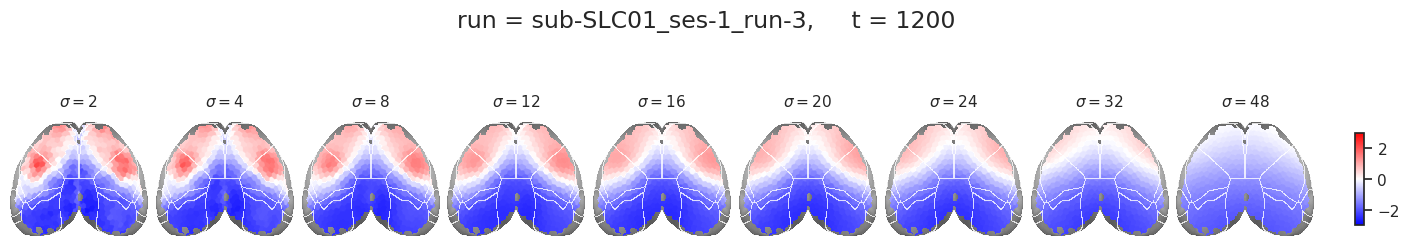

In [7]:
vminmax = 3.0
fig, _ = bs.show(
    data, figsize=(14, 1.6),
    vmin=-vminmax, vmax=vminmax,
    cmap='bwr', cbar=True,
    cbar_pad=0.3, cbar_shrink=0.7, cbar_aspect=10,
    label_fontsize=11,
    layout='constrained',
    titles=[r"$\sigma = $" + str(s) for s in sigmas],
    display=False,
)
sup = fig.suptitle(f"run = {key},     t = {t}", fontsize=17, y=1.5)
fig.savefig(
    pjoin(fig_dir, 'smoothened_eg_timepoint.png'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
    dpi=200,
)
display(fig)

## Variogram

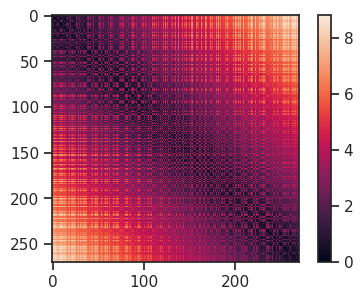

In [8]:
distances_left = np.load(
    pjoin(tmp_dir, 'euclidean_dists_left_hemis.npy'),
    allow_pickle=True,
).item()
d_square = np.zeros((len(bs.l_idxs),) * 2)
for (src, tgt), d in distances_left.items():
    d_square[bs.id2n[src], bs.id2n[tgt]] = d
d_square += d_square.T
d_square /= 100

plt.imshow(d_square)
plt.colorbar();

In [9]:
d = np.load(
    pjoin(tmp_dir, 'degrees.npy'),
    allow_pickle=True,
).item()

dr = np.load(
    pjoin(tmp_dir, 'degree_ranks.npy'),
    allow_pickle=True,
).item()

## Create/save degree ranks for sigma smoothed ca

In [10]:
%%time

b = (0.01, 0.5)
for sig in sigmas:
    desc = f"sig{sig:0.0f}"
    mice.set_kws(desc_ca2=desc, band_ca2=b)
    deg = collect_degrees_lite(
        mice=mice,
        mode='ca2',
        rho=0.15,
        filter_isolated=True,
    )
    if not len(deg):
        continue
    deg = np.stack(list(
        deg.values()))
    d[sig] = bn.nanmean(deg, 0)

    deg_ranks = np_nans(deg.shape)
    for i, x in enumerate(deg):
        good = np.isfinite(x)
        if not good.sum():
            continue
        _ranked = sp_stats.rankdata(x[good])
        _ranked /= np.nanmax(_ranked)
        deg_ranks[i, good] = _ranked
    deg_ranks = bn.nanmean(deg_ranks, 0)
    dr[sig] = deg_ranks

CPU times: user 4min 52s, sys: 5.52 s, total: 4min 57s
Wall time: 5min 7s


#### Plot degree rank

In [11]:
{k: (np.nanmin(v), np.nanmax(v)) for k, v in dr.items()}

{
    'BOLD': (0.21269394878330333, 0.7681680279339376),
    'CAS': (0.07455426045514849, 0.9314761472712783),
    'CAF': (0.009846819005735, 0.9645000892574231),
    2: (0.05153764343473788, 0.940640673578736),
    4: (0.056358885994562465, 0.9309018906638009),
    8: (0.030255719536509122, 0.9053047044482732),
    12: (0.02044037547283182, 0.8901562961959857),
    16: (0.015645089944197253, 0.8857406511517651),
    20: (0.01424311740578582, 0.9012294197648353),
    24: (0.015075421860242945, 0.9047434739946668),
    32: (0.016007099327698966, 0.906760900217955),
    48: (0.013530211130204174, 0.9140972052928753)
}

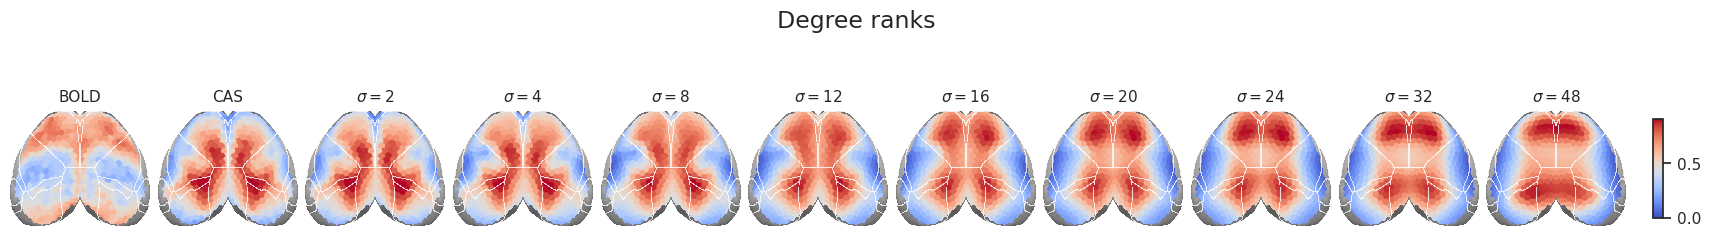

In [12]:
fig, _ = bs.show(
    data=np.stack([
        v for k, v in dr.items()
        if k != 'CAF']),
    titles=[
        k if isinstance(k, str)
        else r"$\sigma = $" + str(k)
        for k in dr if k != 'CAF'],
    vmin=0, vmax=0.9, figsize=(17, 1.5),
    label_fontsize=11, title_y=1.01,
    cbar_shrink=0.8, cbar_pad=0.2,
    cbar=True, cbar_aspect=10,
    cmap='coolwarm',
    layout='constrained',
    display=False,
)
sup = fig.suptitle(f"Degree ranks", fontsize=17, y=1.5)
fig.savefig(
    pjoin(fig_dir, 'smoothened_degree_ranks.png'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
    dpi=200,
)
display(fig)

#### Plot degree

In [13]:
{k: (np.nanmin(v), np.nanmax(v)) for k, v in d.items()}

{
    'BOLD': (42.44736842105263, 123.64545454545454),
    'CAS': (14.851063829787234, 161.45045045045046),
    'CAF': (1.5, 196.04504504504504),
    2: (11.115384615384615, 153.16216216216216),
    4: (25.061728395061728, 141.8918918918919),
    8: (24.96875, 126.28828828828829),
    12: (25.25, 117.95495495495496),
    16: (26.15625, 114.009009009009),
    20: (27.6875, 115.71171171171171),
    24: (29.140625, 115.98198198198199),
    32: (30.4375, 113.69369369369369),
    48: (31.171875, 108.98611111111111)
}

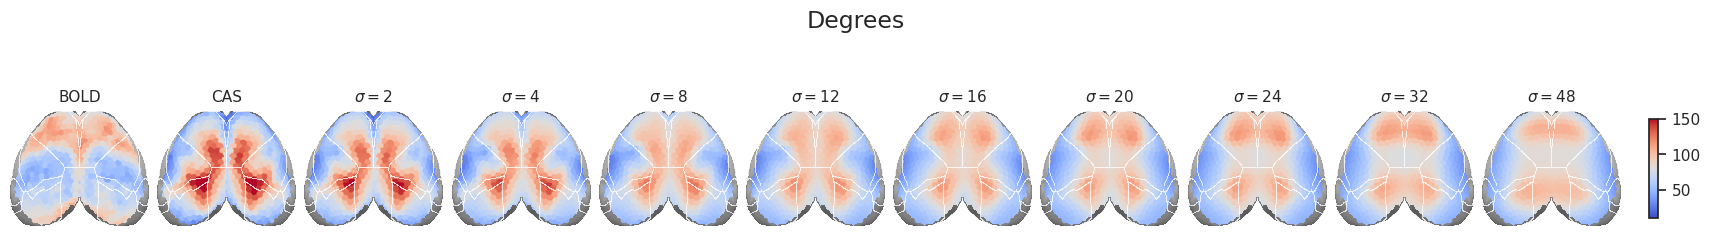

In [14]:
fig, _ = bs.show(
    data=np.stack([
        v for k, v in d.items()
        if k != 'CAF']),
    titles=[
        k if isinstance(k, str)
        else r"$\sigma = $" + str(k)
        for k in d if k != 'CAF'],
    figsize=(17, 1.5), vmin=10, vmax=150, 
    label_fontsize=11, title_y=1.01,
    cbar_shrink=0.8, cbar_pad=0.2,
    cbar=True, cbar_aspect=10,
    cmap='coolwarm',
    layout='constrained',
    display=False,
)
sup = fig.suptitle(f"Degrees", fontsize=17, y=1.5)
fig.savefig(
    pjoin(fig_dir, 'smoothened_degrees.png'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
    dpi=200,
)
display(fig)

## BrainSMASH

In [56]:
sys.path.insert(0, os.path.join(git_dir, 'brainsmash'))
from brainsmash.mapgen.base import Base as Brainsmash_BS

## Deg rank

In [57]:
gamma = {}
for k, v in dr.items():
    x = v[bs.l_idxs]
    good = ~np.isnan(x)
    x = x[good]

    base = Brainsmash_BS(
        x=x,
        D=d_square[good][:, good],
        pv=40,
    )
    gamma[k] = base.compute_smooth_variogram(x)

In [58]:
pal_sig = sns.color_palette('Purples', n_colors=14)
pal_sig

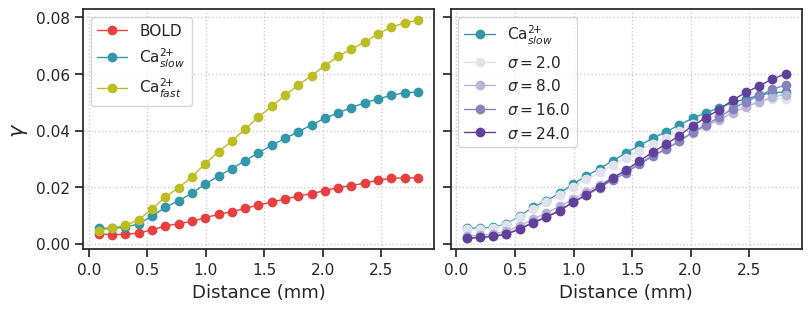

In [59]:
fig, axes = create_figure(1, 2, (8.0, 3.0), sharey='all', layout='constrained')

ax = axes[0]
for mode in gamma:
    if mode not in translation:
        continue
    ax.plot(
        base.h,
        gamma[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
ax.set_ylabel(r'$\gamma$', fontsize=15)
ax.set_xlabel('Distance (mm)', fontsize=13)
# move_legend(ax, (1., 1.03))

ax = axes[1]
mode = 'CAS'
ax.plot(
    base.h,
    gamma[mode],
    color=pal[translation[mode]],
    label=translation[mode],
    marker='o',
    lw=1,
)
for i, sig in enumerate([2, 8, 16, 24]):
    if sig not in gamma:
        continue
    ax.plot(
        base.h,
        gamma[sig],
        color=pal_sig[2 + 3 * i],
        label=r"$\sigma = $" + f"{sig:0.1f}",
        marker='o',
        lw=1,
    )
ax.set_xlabel('Distance (mm)', fontsize=13)

for ax in axes.flat:
    ax.legend(loc='upper left', fontsize=11)
    ax.grid()

fig.savefig(
    pjoin(fig_dir, f"variogram_smoothened_degree_rank.pdf"),
    bbox_inches='tight',
)
plt.show()

## Deg

In [60]:
gamma = {}
for k, v in d.items():
    x = v[bs.l_idxs]
    good = ~np.isnan(x)
    x = x[good]

    base = Brainsmash_BS(
        x=x,
        D=d_square[good][:, good],
        pv=40,
    )
    gamma[k] = base.compute_smooth_variogram(x)

In [61]:
pal_sig = sns.color_palette('Purples', n_colors=14)
pal_sig

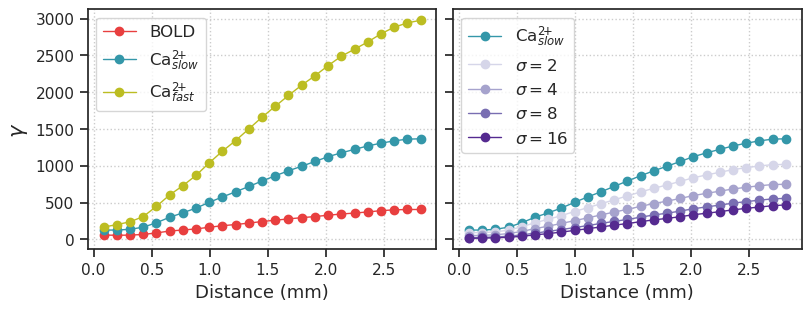

In [62]:
fig, axes = create_figure(1, 2, (8.0, 3.0), sharey='all', layout='constrained')

ax = axes[0]
for mode in gamma:
    if mode not in translation:
        continue
    ax.plot(
        base.h,
        gamma[mode],
        color=pal[translation[mode]],
        label=translation[mode],
        marker='o',
        lw=1,
    )
ax.set_ylabel(r'$\gamma$', fontsize=15)
ax.set_xlabel('Distance (mm)', fontsize=13)

ax = axes[1]
mode = 'CAS'
ax.plot(
    base.h,
    gamma[mode],
    color=pal[translation[mode]],
    label=translation[mode],
    marker='o',
    lw=1,
)
for i, sig in enumerate([2, 4, 8, 16]):
    if sig not in gamma:
        continue
    ax.plot(
        base.h,
        gamma[sig],
        color=pal_sig[3 + 3 * i],
        label=r"$\sigma = $" + f"{sig:0.0f}",
        marker='o',
        lw=1,
    )
ax.set_xlabel('Distance (mm)', fontsize=13)

for ax in axes.flat:
    ax.legend(loc='upper left', fontsize=12)
    ax.grid()

fig.savefig(
    pjoin(fig_dir, f"variogram_smoothened_degree.pdf"),
    bbox_inches='tight',
)
plt.show()

## Take a look at actual data

In [35]:
key = 'sub-SLC01_ses-1_run-3'

In [42]:
times = [1200, 1500, 1600, 2500, 4000]
data = np.zeros((len(times), len(sigmas), bs.num_n))
for j, sig in enumerate(sigmas):
    mice.setup_func_data(
        band_ca2=(0.01, 0.5),
        desc_ca2=f"sig{sig:0.0f}",
    )
    try:
        x = Base(
            mice=mice,
            mode='ca2',
            key=key,
            prep_data=True,
        ).data
    except AttributeError:
        continue

    x = sp_stats.zscore(x, -1)
    
    for i, t in enumerate(times):
        data[i, j] = x[:, t]

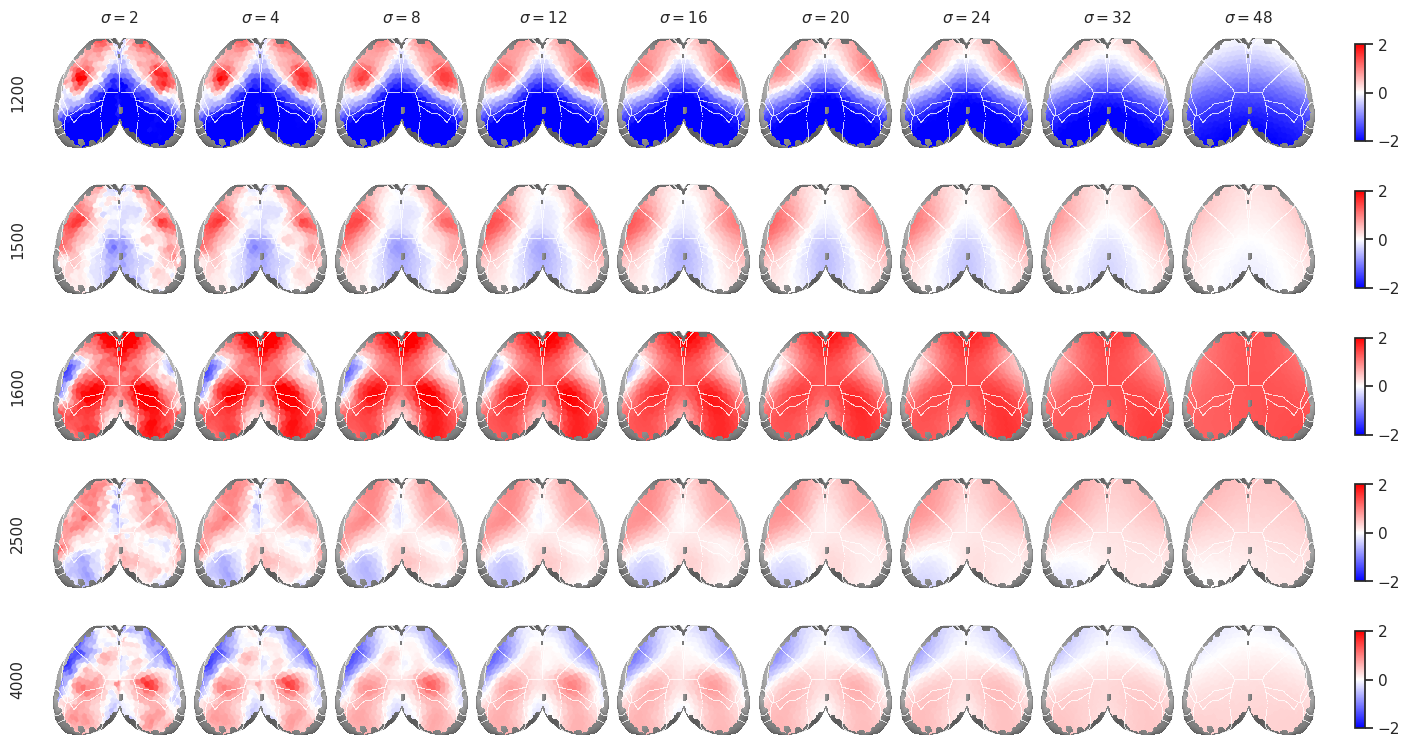

In [45]:
vminmax = 2.0
_ = bs.show(
    data={times[i]: x for i, x in enumerate(data)},
    figsize=(14, 1.5 * len(times)),
    vmin=-vminmax, vmax=vminmax,
    cmap='bwr', cbar=True,
    cbar_pad=0.3, cbar_shrink=0.7, cbar_aspect=10,
    label_fontsize=11,
    layout='constrained',
    titles=[r"$\sigma = $" + str(s) for s in sigmas],
)

In [58]:
gs = np.mean(raw[mask == 1.0], 0)

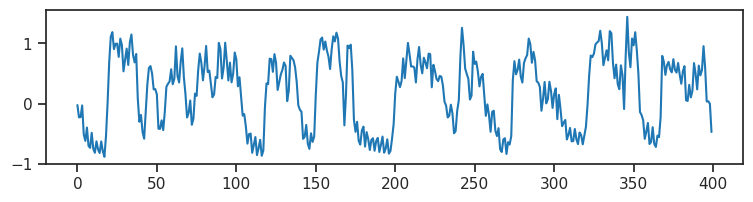

In [64]:
fig, ax = create_figure(1 , 1, (9, 2))
plt.plot(gs[2000:2400]);

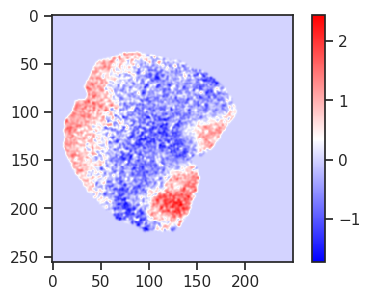

In [72]:
plt.imshow(raw[..., 1200], cmap='bwr')
plt.colorbar();

In [66]:
from register.register import Register

mode = 'ca2'
reg = Register(mice)
reg.set_mode(mode)

In [70]:
cols = reg.load_obj_masks(key_ses, 'cols')['cols']
cols = cols.numpy()

<matplotlib.image.AxesImage object at 0x7f4ef02fb700>

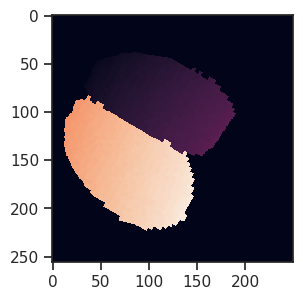

In [71]:
plt.imshow(cols)